<a href="https://colab.research.google.com/github/VaishnaviAgrawal03/LiverGuard-Research-Intern/blob/master/Copy_of_LiverGuardAdv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost catboost shap optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.7 MB/s eta 0:00:00


# **Importing Necessary Libraries:**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import SMOTE

import optuna
from optuna.samplers import TPESampler

from google.colab import drive
drive.mount('/content/drive')

RANDOM_STATE = 42


#**Loading the dataset:**

In [ ]:
data = pd.read_csv('/content/drive/My Drive/dataset.csv')

import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

data = data.drop(columns=["S. No."])  # Drop serial number
data['Liver Healthy'] = data['Liver Healthy'].map({'Yes': 1, 'No': 0})  # Binary encoding

# Split features and labels
df_features = data.drop(columns=["Liver Healthy"])
df_labels = data["Liver Healthy"]

# Dataset A: Noise-Augmented with varied noise distributions
def generate_dataset_with_noise_improved(df, labels, n_samples=250, noise_level_numeric=0.05, noise_level_categorical=0.01):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    cat_cols = df.select_dtypes(exclude=[np.number]).columns
    new_data = []
    new_labels = []
    for _ in range(n_samples):
        idx = np.random.randint(0, len(df))
        row = df.iloc[idx].copy()
        label = labels.iloc[idx]
        # Add noise to numeric features with different distributions
        for col in numeric_cols:
            noise_type = np.random.choice(['normal', 'uniform'])
            if noise_type == 'normal':
                noise = np.random.normal(0, noise_level_numeric * df[col].std())
            else: # uniform
                noise = np.random.uniform(-noise_level_numeric * df[col].std(), noise_level_numeric * df[col].std())
            row[col] += noise
            if col == "Age":
                row[col] = int(round(row[col]))
        # Add noise to categorical features (randomly flip a small percentage)
        for col in cat_cols:
            if np.random.rand() < noise_level_categorical:
                unique_values = df[col].unique()
                row[col] = np.random.choice(unique_values)
        # Ensure numeric values stay within original range
        for col in numeric_cols:
            row[col] = np.clip(row[col], df[col].min(), df[col].max())
        new_data.append(row)
        new_labels.append(label)
    df_aug = pd.DataFrame(new_data)
    df_aug['Liver Healthy'] = new_labels
    return df_aug

# Dataset B: Class-wise Statistical Sampling with added randomness
def generate_dataset_statistical_improved(df, labels, n_samples=250):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    cat_cols = df.select_dtypes(exclude=[np.number]).columns
    df_0 = df[labels == 0]
    df_1 = df[labels == 1]
    data_gen = []
    labels_gen = []
    for _ in range(n_samples):
        label = np.random.choice([0, 1])
        source_df = df_0 if label == 0 else df_1
        new_row = {}
        # Sample numeric features based on class-wise statistics with some randomness
        for col in numeric_cols:
            mu = source_df[col].mean()
            sigma = source_df[col].std()
            val = np.random.normal(mu, sigma) * np.random.uniform(0.8, 1.2) # Add randomness to scaling
            val = np.clip(val, df[col].min(), df[col].max())
            new_row[col] = int(round(val)) if col == "Age" else val
        # Sample categorical features based on class-wise distribution by resampling
        for col in cat_cols:
             if not source_df[col].empty:
                new_row[col] = source_df[col].sample(n=1, replace=True).values[0]
             else:
                # Fallback to sampling from the entire column if the class subset is empty
                new_row[col] = df[col].sample(n=1, replace=True).values[0]
        data_gen.append(new_row)
        labels_gen.append(label)
    df_generated = pd.DataFrame(data_gen)
    df_generated['Liver Healthy'] = labels_gen
    return df_generated

# Dataset C: SMOTE-like Interpolation with extrapolation
def generate_dataset_interpolation_extrapolation(df, labels, n_samples=250, k=3, extrapolation_factor=0.2):
    numeric_df = df.select_dtypes(include=[np.number])
    categorical_df = df.select_dtypes(exclude=[np.number])
    new_data = []
    new_labels = []
    for label in [0, 1]:
        df_label = numeric_df[labels == label].reset_index(drop=True)
        cats_label = categorical_df[labels == label].reset_index(drop=True)
        if len(df_label) > k: # Ensure there are enough samples for k-neighbors
            nbrs = NearestNeighbors(n_neighbors=k+1).fit(df_label)
            for _ in range(n_samples // 2):
                idx = np.random.randint(0, len(df_label))
                _, indices = nbrs.kneighbors([df_label.iloc[idx]])
                neighbor_idx = np.random.choice(indices[0][1:])
                row1 = df_label.iloc[idx]
                row2 = df_label.iloc[neighbor_idx]
                # Interpolation or Extrapolation
                alpha = np.random.uniform(-extrapolation_factor, 1 + extrapolation_factor)
                interp_row = row1 + alpha * (row2 - row1)
                interp_row["Age"] = int(round(interp_row["Age"]))
                # Ensure numeric values stay within original range after interpolation/extrapolation
                for col in numeric_df.columns:
                    interp_row[col] = np.clip(interp_row[col], df[col].min(), df[col].max())

                cat_row = cats_label.iloc[idx].copy() # Keep original categorical features for simplicity
                combined = pd.concat([interp_row, cat_row])
                new_data.append(combined)
                new_labels.append(label)
        else: # If not enough samples, just resample existing data
            for _ in range(n_samples // 2):
                idx = np.random.randint(0, len(df_label))
                combined = pd.concat([df_label.iloc[idx], cats_label.iloc[idx]])
                new_data.append(combined)
                new_labels.append(label)


    df_interp = pd.DataFrame(new_data)
    df_interp['Liver Healthy'] = new_labels
    return df_interp


# Generate all datasets with improved techniques
dataset_a = generate_dataset_with_noise_improved(df_features, df_labels, n_samples=250)
dataset_b = generate_dataset_statistical_improved(df_features, df_labels, n_samples=250)
dataset_c = generate_dataset_interpolation_extrapolation(df_features, df_labels, n_samples=250)

df = pd.concat([data, dataset_a, dataset_b, dataset_c], ignore_index=True)
df['Liver Healthy'] = df['Liver Healthy'].map({0: 'No', 1: 'Yes'})  # Decode label back
df.to_csv("final_augmented_dataset.csv", index=False)

print(df.describe())
print(df.info())
print(df.head())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/

              Age            R            G            B            C  \
count  837.000000   837.000000   837.000000   837.000000   837.000000   
mean    29.377539   747.357166   509.498414   327.607948  1570.720440   
std     18.014438   488.441640   370.109250   235.196302  1102.385306   
min     19.000000    54.000000    29.570000    20.570000    96.710000   
25%     19.000000   326.840355   187.875794   126.699719   593.838348   
50%     21.000000   638.524695   385.950709   253.914325  1225.728342   
75%     28.000000  1065.600969   832.200050   527.135008  2545.262418   
max     85.000000  2058.830000  1554.290000  1095.860000  4302.710000   

        Temp90614   Temp90640          GSR         BMI  
count  837.000000  837.000000   837.000000  837.000000  
mean    30.813608   33.741168   460.662480   24.461910  
std      3.529630    3.723717   355.316705    4.544464  
min     22.170000   24.140000     9.570000   16.360000  
25%     28.772003   31.058224   187.894220   20.937183  


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


# **Yellowness Index Calculation:**

In [ ]:
R, G, B, C = df["R"].astype(float), df["G"].astype(float), df["B"].astype(float), df["C"].astype(float)

rgb = np.stack([R, G, B], axis=1)
C_array = C.to_numpy().reshape(-1, 1)
rgb_norm = rgb / np.clip(C_array, 1e-6, None)

gray_world_avg = np.mean(rgb_norm, axis=0)
rgb_balanced = np.clip(rgb_norm / gray_world_avg, 0, 1)

gamma = 2.2
rgb_linear = np.power(rgb_balanced, gamma)

M_sRGB_D65 = np.array([
    [0.4124564, 0.3575761, 0.1804375],
    [0.2126729, 0.7151522, 0.0721750],
    [0.0193339, 0.1191920, 0.9503041]
])
xyz = rgb_linear @ M_sRGB_D65.T
X, Y, Z = xyz[:, 0], xyz[:, 1], xyz[:, 2]

scaler_xyz = RobustScaler()
X_scaled, Y_scaled, Z_scaled = scaler_xyz.fit_transform(np.stack([X, Y, Z], axis=1)).T

Cx, Cz = 1.2769, 1.0592
YI_raw = 100 * (Cx * X_scaled - Cz * Z_scaled) / np.clip(Y_scaled, 1e-6, None)
df["Yellowness Index"] = (YI_raw - YI_raw.min()) / (YI_raw.max() - YI_raw.min())

df.drop(["R", "G", "B", "C"], axis=1, inplace=True)

# **Encoding and SMOTE:**

In [ ]:
df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0}).astype(float)
df["Liver Healthy"] = df["Liver Healthy"].map({"Yes": 0, "Mid": 1, "No": 1}).astype(float)
df.rename(columns={"Temp90614": "BodyTemp", "Temp90640": "LiverTemp"}, inplace=True)

print("\nClass Distribution Before Balancing:")
print(df["Liver Healthy"].value_counts(normalize=True))

X = df.drop(["Liver Healthy"], axis=1)
y = df["Liver Healthy"]
print("\nApplying SMOTE for Balancing...")
sm = SMOTE(random_state=RANDOM_STATE)
X, y = sm.fit_resample(X, y)

print("\nClass Distribution After Balancing:")
print(pd.Series(y).value_counts(normalize=True))


Class Distribution Before Balancing:
Liver Healthy
0.0    0.62963
1.0    0.37037
Name: proportion, dtype: float64

Applying SMOTE for Balancing...

Class Distribution After Balancing:
Liver Healthy
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


# **Train-Test Split:**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Correlation Matrix:**

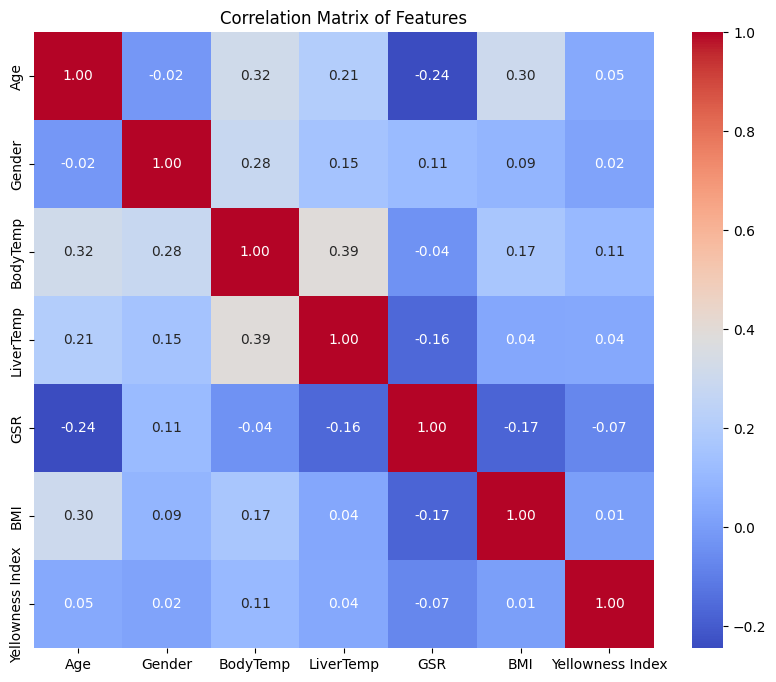

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(X).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Features")
plt.show()


# **Hyperparameter Tuning:**

In [ ]:
def tune_model(trial, model_name):
    if model_name == "RandomForest":
        return RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 500),
            max_depth=trial.suggest_int("max_depth", 3, 20),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 4),
            class_weight="balanced",
            random_state=RANDOM_STATE,
        )
    elif model_name == "LogisticRegression":
        return LogisticRegression(
            C=trial.suggest_float("C", 0.001, 10, log=True),
            penalty="l2",
            solver="lbfgs",
            max_iter=1000,
            class_weight="balanced",
        )
    elif model_name == "SVM_RBF":
        return SVC(
            kernel="rbf",
            C=trial.suggest_float("C", 0.1, 10, log=True),
            gamma=trial.suggest_categorical("gamma", ["scale", "auto"]),
            probability=True,
            class_weight="balanced",
        )
    elif model_name == "SVM_Poly":
        return SVC(
            kernel="poly",
            C=trial.suggest_float("C", 0.1, 10, log=True),
            degree=trial.suggest_int("degree", 2, 5),
            probability=True,
            class_weight="balanced",
        )
    elif model_name == "XGBoost":
        return XGBClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 500),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            subsample=trial.suggest_float("subsample", 0.6, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
            eval_metric="logloss",
            random_state=RANDOM_STATE,
        )
    elif model_name == "CatBoost":
        return CatBoostClassifier(
            iterations=trial.suggest_int("iterations", 100, 500),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            depth=trial.suggest_int("depth", 4, 10),
            verbose=0,
            random_state=RANDOM_STATE,
        )

def objective(trial, model_name):
    model = tune_model(trial, model_name)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        model.fit(X_train[train_idx], y_train.iloc[train_idx])
        y_proba = model.predict_proba(X_train[val_idx])[:, 1]
        scores.append(roc_auc_score(y_train.iloc[val_idx], y_proba))
    return np.nanmean(scores) # Use nanmean to handle NaN scores


models_to_tune = ["RandomForest", "LogisticRegression", "SVM_RBF", "SVM_Poly", "XGBoost", "CatBoost"]
best_estimators = {}

for model_name in models_to_tune:
    print(f"\n🔄 Tuning {model_name}...")
    study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=RANDOM_STATE))
    study.optimize(lambda trial: objective(trial, model_name), n_trials=20, show_progress_bar=False)
    best_estimators[model_name] = tune_model(study.best_trial, model_name)
    best_estimators[model_name].fit(X_train, y_train)

[I 2025-07-17 07:43:26,123] A new study created in memory with name: no-name-dab37f32-3750-4b4b-ad93-5b5450ef6942



🔄 Tuning RandomForest...


[I 2025-07-17 07:43:33,201] Trial 0 finished with value: 0.973031545951714 and parameters: {'n_estimators': 250, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.973031545951714.
[I 2025-07-17 07:43:36,436] Trial 1 finished with value: 0.9539155662264907 and parameters: {'n_estimators': 162, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.973031545951714.
[I 2025-07-17 07:43:46,489] Trial 2 finished with value: 0.9706682673069228 and parameters: {'n_estimators': 341, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.973031545951714.
[I 2025-07-17 07:43:50,582] Trial 3 finished with value: 0.9651847405628917 and parameters: {'n_estimators': 433, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.973031545951714.
[I 2025-07-17 07:43:52,704] Trial 4 finished with value: 0.9759060290782979 and parameters: {'n_est


🔄 Tuning LogisticRegression...


[I 2025-07-17 07:44:50,234] Trial 0 finished with value: 0.8910204081632653 and parameters: {'C': 0.03148911647956861}. Best is trial 0 with value: 0.8910204081632653.
[I 2025-07-17 07:44:50,308] Trial 1 finished with value: 0.8916656662665066 and parameters: {'C': 6.351221010640703}. Best is trial 1 with value: 0.8916656662665066.
[I 2025-07-17 07:44:50,383] Trial 2 finished with value: 0.8920348139255703 and parameters: {'C': 0.8471801418819978}. Best is trial 2 with value: 0.8920348139255703.
[I 2025-07-17 07:44:50,449] Trial 3 finished with value: 0.8918390689609177 and parameters: {'C': 0.24810409748678125}. Best is trial 2 with value: 0.8920348139255703.
[I 2025-07-17 07:44:50,515] Trial 4 finished with value: 0.8877694411097773 and parameters: {'C': 0.004207988669606638}. Best is trial 2 with value: 0.8920348139255703.
[I 2025-07-17 07:44:50,556] Trial 5 finished with value: 0.8877694411097773 and parameters: {'C': 0.004207053950287938}. Best is trial 2 with value: 0.89203481392


🔄 Tuning SVM_RBF...


[I 2025-07-17 07:44:53,001] Trial 0 finished with value: 0.9171475256769375 and parameters: {'C': 0.5611516415334505, 'gamma': 'scale'}. Best is trial 0 with value: 0.9171475256769375.
[I 2025-07-17 07:44:53,221] Trial 1 finished with value: 0.9266353207949847 and parameters: {'C': 1.5751320499779735, 'gamma': 'scale'}. Best is trial 1 with value: 0.9266353207949847.
[I 2025-07-17 07:44:53,514] Trial 2 finished with value: 0.901857576363879 and parameters: {'C': 0.13066739238053282, 'gamma': 'scale'}. Best is trial 1 with value: 0.9266353207949847.
[I 2025-07-17 07:44:53,735] Trial 3 finished with value: 0.9321822062158198 and parameters: {'C': 2.607024758370768, 'gamma': 'auto'}. Best is trial 3 with value: 0.9321822062158198.
[I 2025-07-17 07:44:53,956] Trial 4 finished with value: 0.9364052287581698 and parameters: {'C': 4.622589001020832, 'gamma': 'scale'}. Best is trial 4 with value: 0.9364052287581698.
[I 2025-07-17 07:44:54,207] Trial 5 finished with value: 0.9079478458049886 an


🔄 Tuning SVM_Poly...


[I 2025-07-17 07:44:57,782] Trial 0 finished with value: 0.8932561357876484 and parameters: {'C': 0.5611516415334505, 'degree': 5}. Best is trial 0 with value: 0.8932561357876484.
[I 2025-07-17 07:44:58,002] Trial 1 finished with value: 0.8851312191543285 and parameters: {'C': 2.9106359131330697, 'degree': 4}. Best is trial 0 with value: 0.8932561357876484.
[I 2025-07-17 07:44:58,217] Trial 2 finished with value: 0.8456322529011604 and parameters: {'C': 0.20513382630874505, 'degree': 2}. Best is trial 0 with value: 0.8932561357876484.
[I 2025-07-17 07:44:58,443] Trial 3 finished with value: 0.8825216753368015 and parameters: {'C': 0.13066739238053282, 'degree': 5}. Best is trial 0 with value: 0.8932561357876484.
[I 2025-07-17 07:44:58,681] Trial 4 finished with value: 0.8810184073629452 and parameters: {'C': 1.5930522616241019, 'degree': 4}. Best is trial 0 with value: 0.8932561357876484.
[I 2025-07-17 07:44:58,910] Trial 5 finished with value: 0.881998799519808 and parameters: {'C': 0


🔄 Tuning XGBoost...


[I 2025-07-17 07:45:03,083] Trial 0 finished with value: 0.9712748432706416 and parameters: {'n_estimators': 250, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746}. Best is trial 0 with value: 0.9712748432706416.
[I 2025-07-17 07:45:06,283] Trial 1 finished with value: 0.9702264239028946 and parameters: {'n_estimators': 162, 'learning_rate': 0.012184186502221764, 'max_depth': 9, 'subsample': 0.8404460046972835, 'colsample_bytree': 0.8832290311184181}. Best is trial 0 with value: 0.9712748432706416.
[I 2025-07-17 07:45:06,565] Trial 2 finished with value: 0.9717567026810725 and parameters: {'n_estimators': 108, 'learning_rate': 0.2708160864249968, 'max_depth': 9, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402}. Best is trial 2 with value: 0.9717567026810725.
[I 2025-07-17 07:45:07,271] Trial 3 finished with value: 0.9730225423502734 and parameters: {'n_estimators': 173, 'learning_rate': 


🔄 Tuning CatBoost...


[I 2025-07-17 07:45:37,876] Trial 0 finished with value: 0.9763408696812057 and parameters: {'iterations': 250, 'learning_rate': 0.2536999076681772, 'depth': 9}. Best is trial 0 with value: 0.9763408696812057.
[I 2025-07-17 07:45:40,100] Trial 1 finished with value: 0.9663065226090437 and parameters: {'iterations': 340, 'learning_rate': 0.01700037298921102, 'depth': 5}. Best is trial 0 with value: 0.9763408696812057.
[I 2025-07-17 07:45:42,747] Trial 2 finished with value: 0.9734380418834201 and parameters: {'iterations': 123, 'learning_rate': 0.19030368381735815, 'depth': 8}. Best is trial 0 with value: 0.9763408696812057.
[I 2025-07-17 07:46:14,518] Trial 3 finished with value: 0.9750573562758437 and parameters: {'iterations': 383, 'learning_rate': 0.010725209743171997, 'depth': 10}. Best is trial 0 with value: 0.9763408696812057.
[I 2025-07-17 07:46:17,314] Trial 4 finished with value: 0.9707179538482059 and parameters: {'iterations': 433, 'learning_rate': 0.020589728197687916, 'dep

# **Evaluation parameters (model-wise):**


✅ Evaluation of RandomForest
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96       106
         1.0       0.95      0.96      0.96       105

    accuracy                           0.96       211
   macro avg       0.96      0.96      0.96       211
weighted avg       0.96      0.96      0.96       211

ROC-AUC: 0.9904


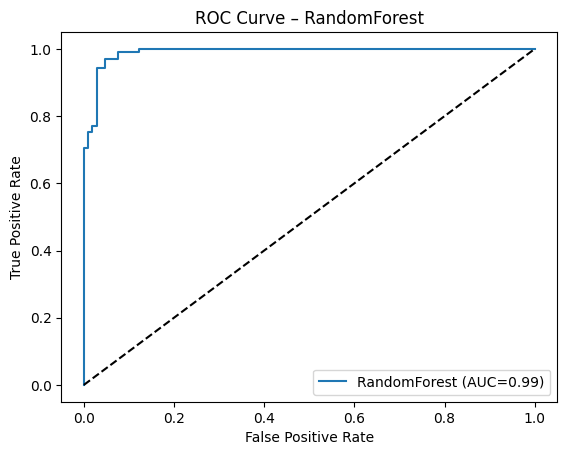


✅ Evaluation of LogisticRegression
              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82       106
         1.0       0.83      0.79      0.81       105

    accuracy                           0.82       211
   macro avg       0.82      0.82      0.82       211
weighted avg       0.82      0.82      0.82       211

ROC-AUC: 0.8878


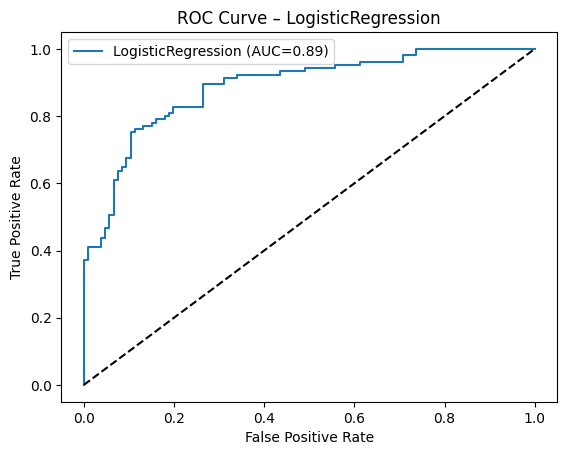


✅ Evaluation of SVM_RBF
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91       106
         1.0       0.89      0.93      0.91       105

    accuracy                           0.91       211
   macro avg       0.91      0.91      0.91       211
weighted avg       0.91      0.91      0.91       211

ROC-AUC: 0.9604


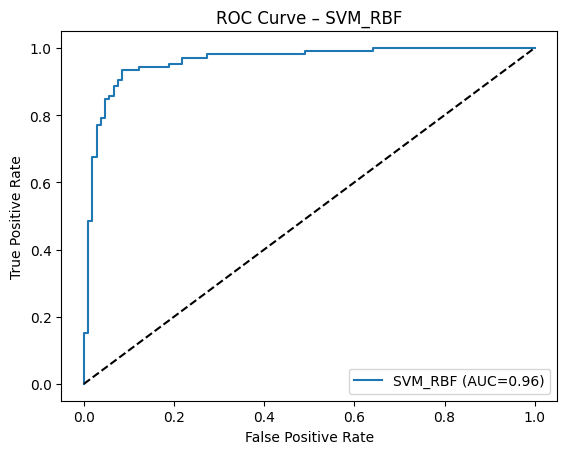


✅ Evaluation of SVM_Poly
              precision    recall  f1-score   support

         0.0       0.79      0.87      0.83       106
         1.0       0.85      0.77      0.81       105

    accuracy                           0.82       211
   macro avg       0.82      0.82      0.82       211
weighted avg       0.82      0.82      0.82       211

ROC-AUC: 0.9045


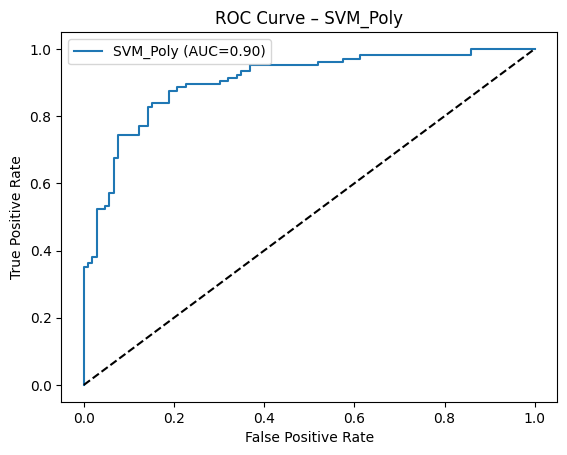


✅ Evaluation of XGBoost
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       106
         1.0       0.97      0.97      0.97       105

    accuracy                           0.97       211
   macro avg       0.97      0.97      0.97       211
weighted avg       0.97      0.97      0.97       211

ROC-AUC: 0.9906


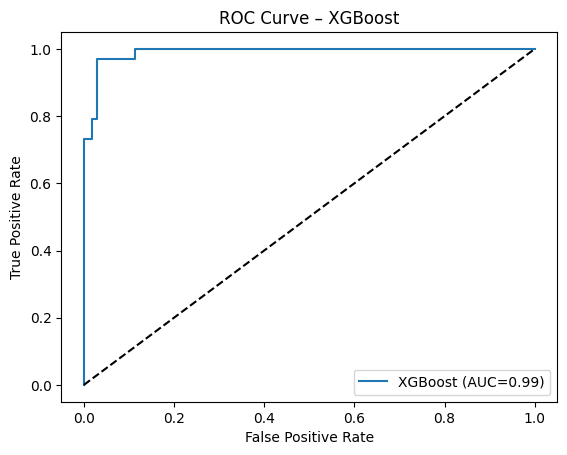


✅ Evaluation of CatBoost
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       106
         1.0       0.96      0.96      0.96       105

    accuracy                           0.96       211
   macro avg       0.96      0.96      0.96       211
weighted avg       0.96      0.96      0.96       211

ROC-AUC: 0.9894


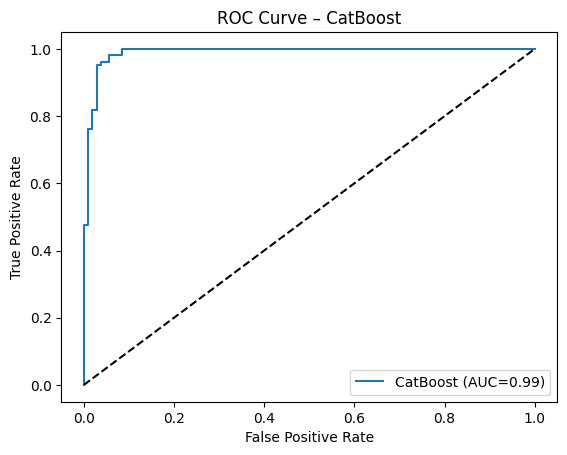

In [ ]:
for name, model in best_estimators.items():
    print(f"\n✅ Evaluation of {name}")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {auc:.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {name}")
    plt.legend()
    plt.show()

# **Ensembling:**


✅ Stacked Model Classification Report
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       106
         1.0       0.95      0.97      0.96       105

    accuracy                           0.96       211
   macro avg       0.96      0.96      0.96       211
weighted avg       0.96      0.96      0.96       211

Stacked Model ROC-AUC: 0.9909


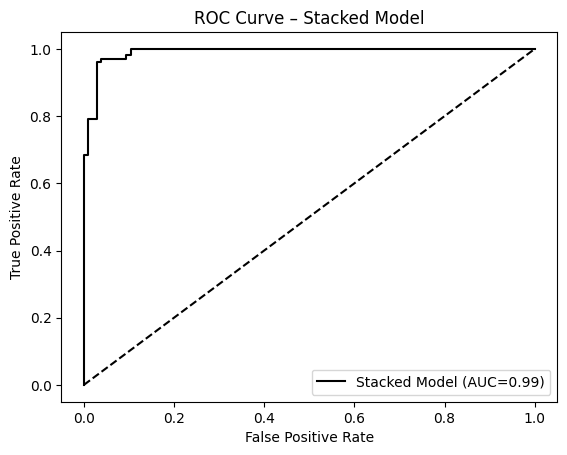


✅ Voting Classifier Classification Report
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96       106
         1.0       0.94      0.97      0.96       105

    accuracy                           0.96       211
   macro avg       0.96      0.96      0.96       211
weighted avg       0.96      0.96      0.96       211

Voting Classifier ROC-AUC: 0.9867


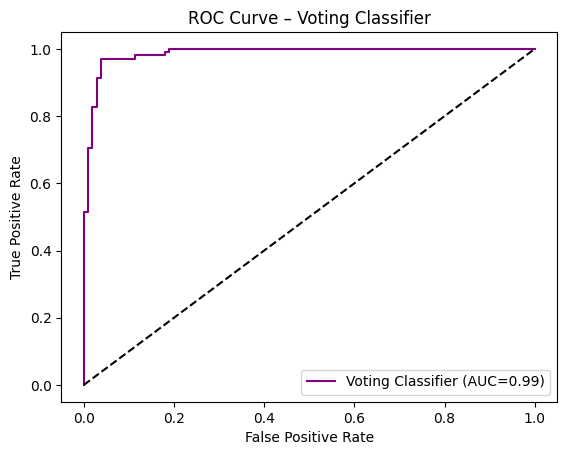

In [ ]:
# Stacking
stack_estimators = [
    ("xgb", best_estimators["XGBoost"]),
    ("cat", best_estimators["CatBoost"]),
    ("rf", best_estimators["RandomForest"]),
    ("svm_rbf", best_estimators["SVM_RBF"]),
    ("svm_poly", best_estimators["SVM_Poly"]),
]
stacked_model = StackingClassifier(
    estimators=stack_estimators,
    final_estimator=LogisticRegression(max_iter=1000)
)
stacked_model.fit(X_train, y_train)

y_pred_stack = stacked_model.predict(X_test)
y_proba_stack = stacked_model.predict_proba(X_test)[:, 1]
print("\n✅ Stacked Model Classification Report")
print(classification_report(y_test, y_pred_stack))
stack_auc = roc_auc_score(y_test, y_proba_stack)
print(f"Stacked Model ROC-AUC: {stack_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_proba_stack)
plt.figure()
plt.plot(fpr, tpr, label=f"Stacked Model (AUC={stack_auc:.2f})", color="black")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Stacked Model")
plt.legend()
plt.show()

# Voting (Soft Voting)
voting_model = VotingClassifier(
    estimators=stack_estimators,
    voting="soft"
)
voting_model.fit(X_train, y_train)

y_pred_vote = voting_model.predict(X_test)
y_proba_vote = voting_model.predict_proba(X_test)[:, 1]
print("\n✅ Voting Classifier Classification Report")
print(classification_report(y_test, y_pred_vote))
vote_auc = roc_auc_score(y_test, y_proba_vote)
print(f"Voting Classifier ROC-AUC: {vote_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_proba_vote)
plt.figure()
plt.plot(fpr, tpr, label=f"Voting Classifier (AUC={vote_auc:.2f})", color="purple")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Voting Classifier")
plt.legend()
plt.show()

# **Feature Importance & SHAP:**


🔍 Feature Importance – RandomForest


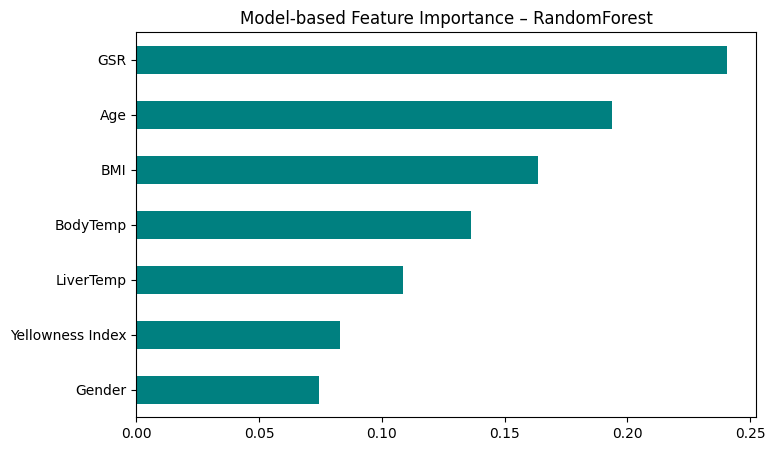

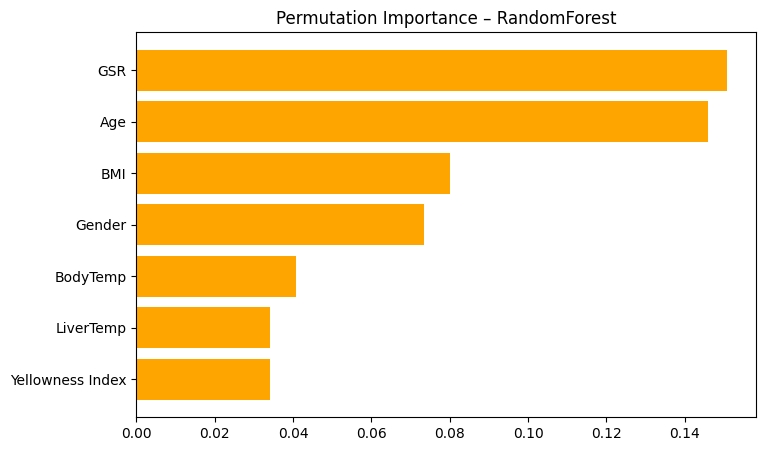

Generating SHAP for RandomForest...


ExactExplainer explainer: 212it [01:03,  3.01it/s]


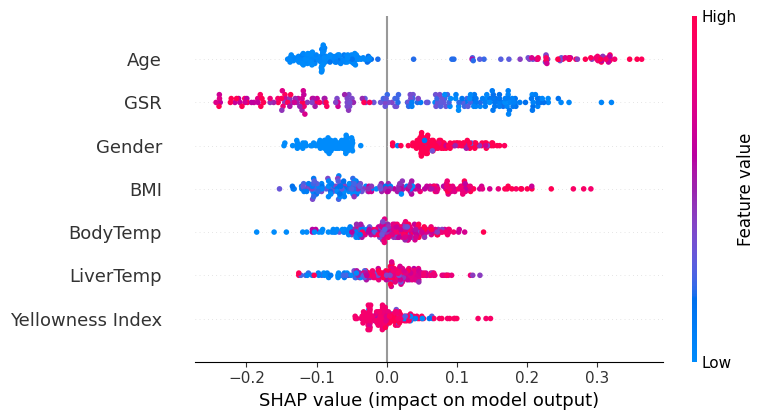


🔍 Feature Importance – LogisticRegression


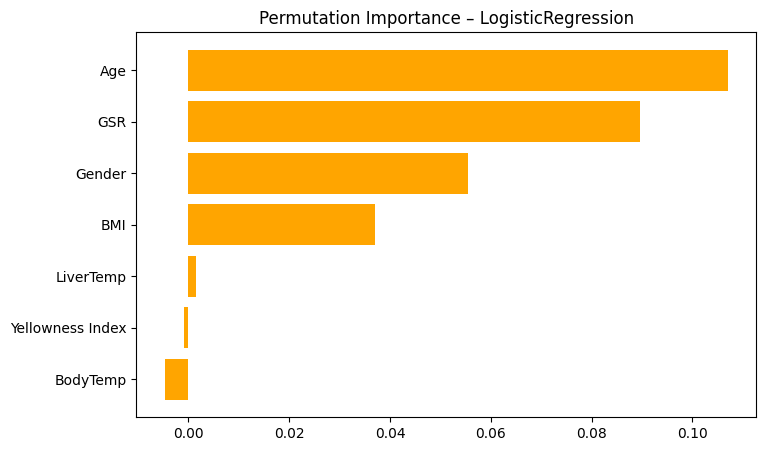

Generating SHAP for LogisticRegression...


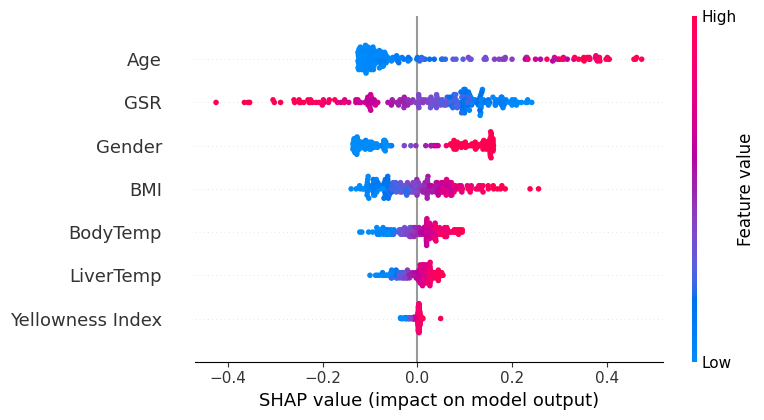


🔍 Feature Importance – SVM_RBF


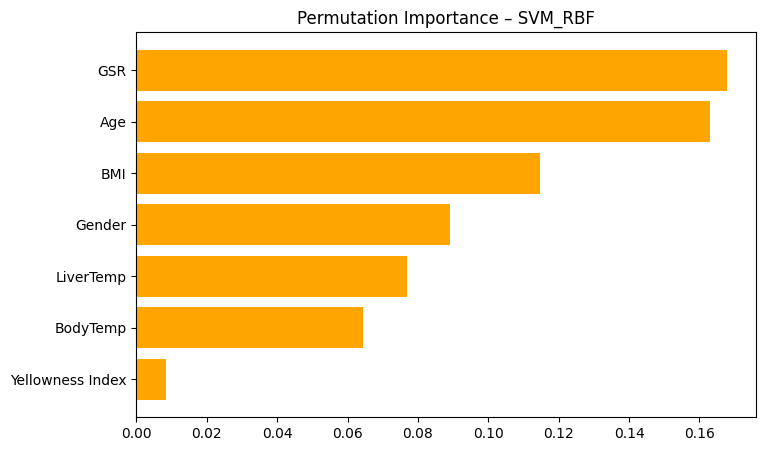

Generating SHAP for SVM_RBF...


ExactExplainer explainer: 212it [00:39,  4.05it/s]


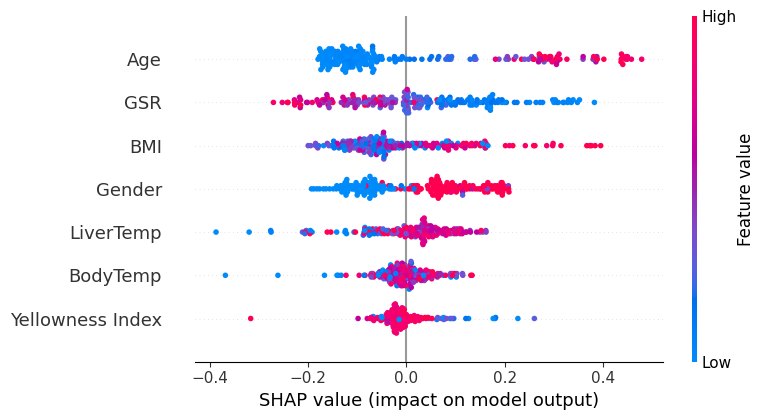


🔍 Feature Importance – SVM_Poly


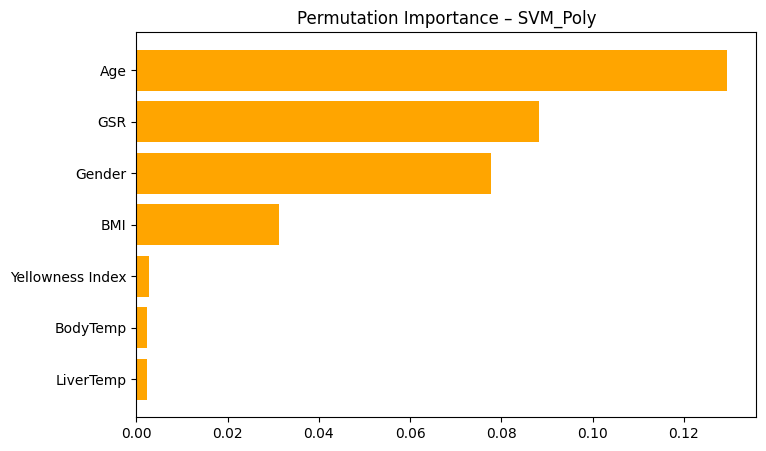

Generating SHAP for SVM_Poly...


ExactExplainer explainer: 212it [00:22,  5.29it/s]


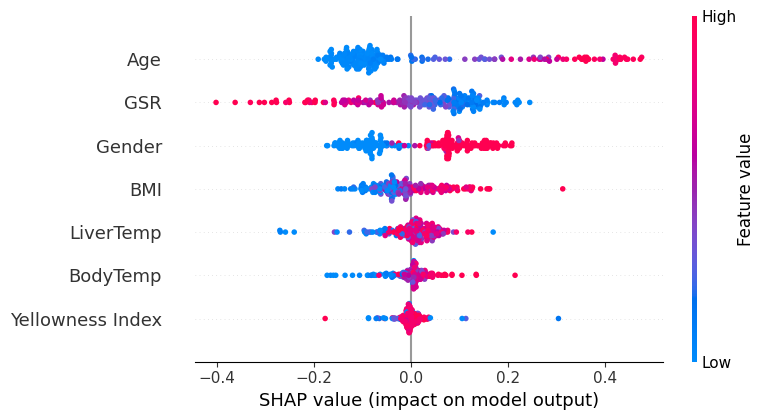


🔍 Feature Importance – XGBoost


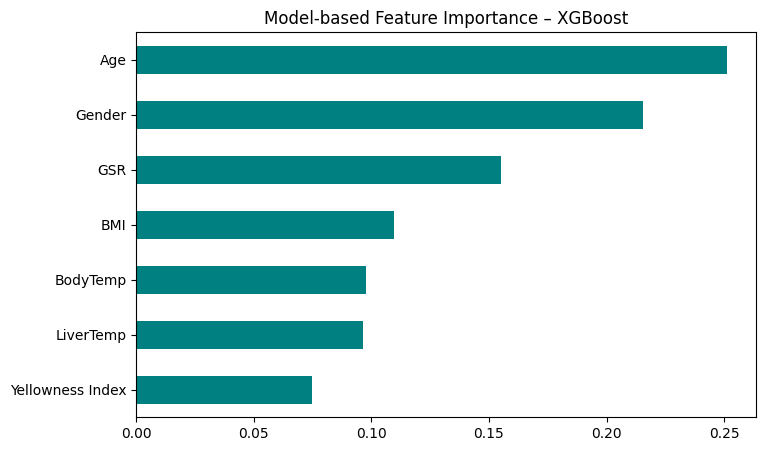

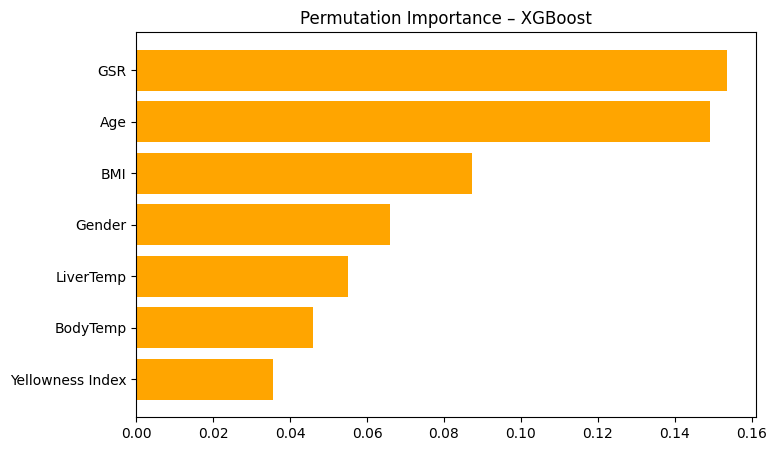

Generating SHAP for XGBoost...


ExactExplainer explainer: 212it [00:26,  4.67it/s]


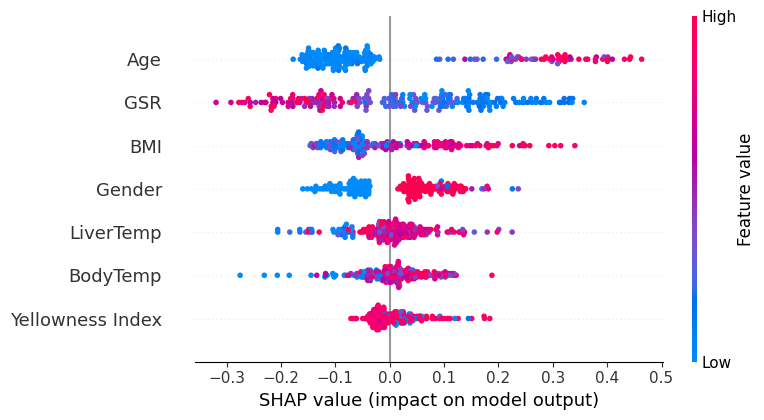


🔍 Feature Importance – CatBoost


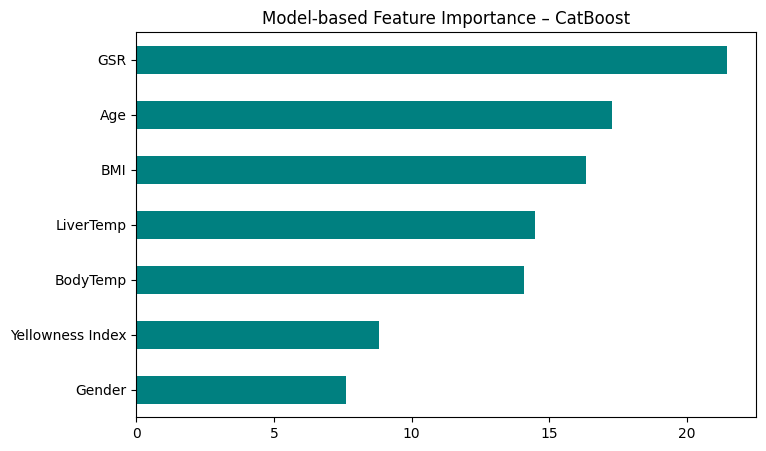

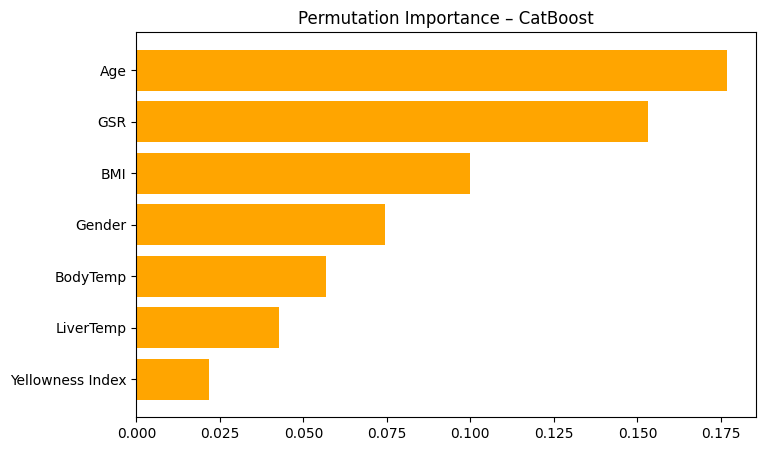

Generating SHAP for CatBoost...


ExactExplainer explainer: 212it [00:12,  1.64it/s]


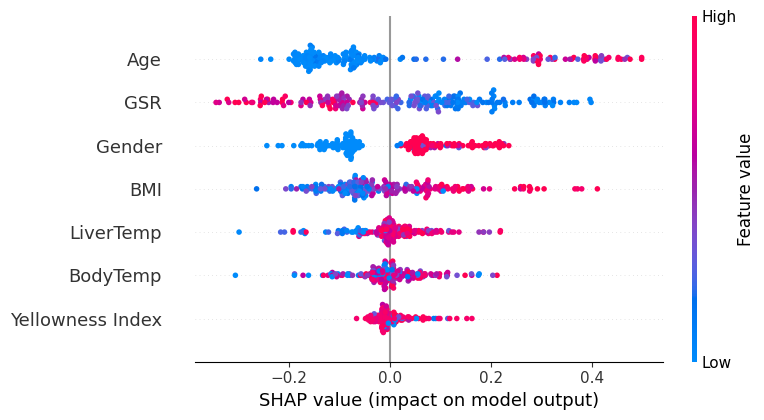

In [ ]:
for name, model in best_estimators.items():
    print(f"\n🔍 Feature Importance – {name}")

    # (1) Model-based (Tree-based models)
    if hasattr(model, "feature_importances_"):
        plt.figure(figsize=(8, 5))
        feat_imp = pd.Series(model.feature_importances_, index=X.columns)
        feat_imp.sort_values().plot(kind="barh", color="teal")
        plt.title(f"Model-based Feature Importance – {name}")
        plt.show()

    # (2) Permutation Importance (All models)
    perm_imp = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE)
    plt.figure(figsize=(8, 5))
    sorted_idx = perm_imp.importances_mean.argsort()
    plt.barh(np.array(X.columns)[sorted_idx], perm_imp.importances_mean[sorted_idx], color="orange")
    plt.title(f"Permutation Importance – {name}")
    plt.show()

    # SHAP
    print(f"Generating SHAP for {name}...")
    explainer = shap.Explainer(model.predict_proba, X_train)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values[:, :, 1], features=X_test, feature_names=X.columns, show=True)

In [ ]:
import joblib
import os

drive_base_path = "/content/drive/My Drive/"
model_dir = os.path.join(drive_base_path, "LiverGuardDeploy")
os.makedirs(model_dir, exist_ok=True)

joblib.dump(stacked_model, os.path.join(model_dir, "stacked_model.pkl"))
joblib.dump(voting_model, os.path.join(model_dir, "voting_model.pkl"))
joblib.dump(scaler, os.path.join(model_dir, "scaler.pkl"))

print(f"✅ Models and scaler saved at: {model_dir}")